# **Foundations of NLP @FMI-UNIBUC**
**Authors**: *Condrat Mihai (411), Guiţă Bianca-Oana (411), Meteşan Raul-Petru (406)*

**Topic**: *15. Hate speech, offensive language identification, misogyny / stereotype detection*


# Setup

Data: drag and drop *olid-training-v1.0.tsv* into the working folder, such that it's path is */content/olid-training-v1.0.tsv*

In [ ]:
installed_dependencies = False

In [ ]:
# small hack to speed up multiple notebook runs
def install_dependencies():
  
  # upgrades
  !pip install --upgrade tensorflow
  !pip install --upgrade ekphrasis

  # NLTK downloads
  import nltk
  nltk.download('punkt')
  nltk.download('stopwords')
  nltk.download('wordnet')

  # Importing pretrained word2vec
  import gensim.downloader 
  # word2vec = gensim.downloader.load('word2vec-google-news-300')

  return True

if not installed_dependencies:
  installed_dependencies = install_dependencies()

In [ ]:
### imports

# data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# models
import sklearn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# text and NLP
import re
import string
import nltk

import gensim.downloader
from gensim.models import Word2Vec

# ekphrasis for NLP
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.spellcorrect import SpellCorrector


# Read the Data

In the first step, the annotators mark the tweet as being offensive or not offensive (Subtask A).

If the tweet is offensive then the annotators need to tell if the offense is targeted towards somebody or something or it is not targeted (Subtask B).

If the offense is targeted then the annotators also need to tell who it is targeted against (Subtask C).


In [ ]:
# Read Data
data = pd.read_csv('olid-training-v1.0.tsv', sep='\t')

# Subtask A: Is this tweet offensive? (0/1)
data['subtask_a'] = data['subtask_a'].replace('NOT', 0)
data['subtask_a'] = data['subtask_a'].replace('OFF', 1)
data['subtask_a'] = data['subtask_a'].fillna(-1).astype(int)

# Subtask B: Is this offensive tweet targeted? (0/1)
data['subtask_b'] = data['subtask_b'].replace('UNT', int(0))
data['subtask_b'] = data['subtask_b'].replace('TIN', int(1))
data['subtask_b'] = data['subtask_b'].fillna(-1).astype(int)

# Subtask C: The target group of this offensive targeted tweet is: individual (0), group (1), other (2)
data['subtask_c'] = data['subtask_c'].replace('IND', int(0))
data['subtask_c'] = data['subtask_c'].replace('GRP', int(1))
data['subtask_c'] = data['subtask_c'].replace('OTH', int(2))
data['subtask_c'] = data['subtask_c'].fillna(-1).astype(int)

# Check DF (All missing values are set to -1)
data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,1,0,-1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1,1,0
2,16820,Amazon is investigating Chinese employees who ...,0,-1,-1
3,62688,"@USER Someone should'veTaken"" this piece of sh...",1,0,-1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,0,-1,-1
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,1,1,0
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,0,-1,-1
13237,82921,@USER And why report this garbage. We don't g...,1,1,2
13238,27429,@USER Pussy,1,0,-1


# Pre-process the Data

In [ ]:
# separate list, used mainly for testing purposes
tweets = data['tweet']

tweets

0        @USER She should ask a few native Americans wh...
1        @USER @USER Go home you’re drunk!!! @USER #MAG...
2        Amazon is investigating Chinese employees who ...
3        @USER Someone should'veTaken" this piece of sh...
4        @USER @USER Obama wanted liberals &amp; illega...
                               ...                        
13235    @USER Sometimes I get strong vibes from people...
13236    Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...
13237    @USER And why report this garbage.  We don't g...
13238                                          @USER Pussy
13239    #Spanishrevenge vs. #justice #HumanRights and ...
Name: tweet, Length: 13240, dtype: object

**Text correction:**

In [ ]:
### long runtime, should be used only on a list containing tweets/words that NEED correction

# text correction helper function
def correct_tweets (tweets_to_correct = []):

  # text corrector
  sp = SpellCorrector(corpus="english") 

  corrected_tweets = []

  # correct each tweet
  for tweet in tweets_to_correct:
    tweet = sp.correct(tweet)
    corrected_tweets.append(tweet)
  
  return corrected_tweets

In [ ]:
# check some tweets
temp = tweets[:1]
print(temp, '\n')

# test the corrector
print(correct_tweets(temp))

0    @USER She should ask a few native Americans wh...
Name: tweet, dtype: object 

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
['@USER She should ask a few native Americans what their take on this is.']


**Remove text contractions:**

In [ ]:
# handle some of the more popular contractions
def remove_contractions (text):
  
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is ", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"it's", " it is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", "  are", text)
    text = re.sub(r"\'d", "  would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'bout", "about", text)
    
    return text

**Remove emojis:**

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r' ', string)

**Text pre-processor:**

In [ ]:
text_processor = TextPreProcessor(
    
    # terms that will be normalized
    normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],

    # terms that will be annotated
    annotate = {"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter = "twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector = "twitter", 
    
    fix_html = False,             # fix HTML tokens
    unpack_hashtags = False,       # perform word segmentation on hashtags
    unpack_contractions = True,   # Unpack contractions (can't -> can not)
    spell_correct_elong = False,  # spell correction for elongated words
    
    # select a tokenizer
    tokenizer = SocialTokenizer(lowercase = True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts = [emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


**Pre-processing:**

In [ ]:
def preprocess_tweets (tweets_to_preprocess = []):

  processed_tweets = []

  for tweet in tweets_to_preprocess:

    # prepare tweet for pre-processing with ekphrasis
    # tweet = text_processor.pre_process_doc(tweet)

    # remove new line characters '\n'
    tweet = tweet.replace("\n", " ")

    # lowercase
    tweet = tweet.lower()

    # remove common contractions
    tweet = remove_contractions(tweet)

    # remove links
    tweet = re.sub(r'http\S+', " ", tweet)

    # remove mentions
    tweet = re.sub(r'@([a-zA-Z0-9_])+', " ", tweet)

    # remove hashtags
    tweet = re.sub(r'#([a-zA-Z0-9_])+', " ", tweet)

    # remove digits
    tweet = re.sub(r'\b\d+\b', " ", tweet)

    # remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # remove emojis and emoticons
    tweet = remove_emoji(tweet)
    tweet = tweet.replace("xD", " ") # manual removal of 2-letter emoticons
    #emoticons are removed at the punctuation & digits part of the preprocessing;
    #we must deal with single letters (e.g. ":P" => " P") at the next step.

    # tokenize tweet into separate words
    tweet = nltk.tokenize.word_tokenize(tweet)

    # remove stopwords
    tweet = [_tweet for _tweet in tweet 
              if _tweet not in nltk.corpus.stopwords.words('english')
              and len(_tweet) > 1]

    # lematization, https://arxiv.org/pdf/1707.01780.pdf finds no significant impact
    # on accuracy for text classification using neural architectures,
    # so we can use lemmatization for classical methods and stemming for NN's
    # tweet = [nltk.WordNetLemmatizer().lemmatize(_tweet) for _tweet in tweet]

    # stemming
    # tweet = [nltk.PorterStemmer().stem(_tweet) for _tweet in tweet]
    tweet = [nltk.SnowballStemmer("english").stem(_tweet) for _tweet in tweet]

    # add the tweet to the processed tweets list
    tweet = " ".join(tweet)
    processed_tweets.append(tweet)

  return processed_tweets

In [ ]:
# check for single tweet (passed as a list)
print(preprocess_tweets([tweets[0]]))

# check the processing
temp = tweets[:10]

print('\n -> Not-Processed:')
for t in temp:
  print(t)

print('\n -> Processed:')
preprocess_tweets(temp)

['ask nativ american take']

 -> Not-Processed:
@USER She should ask a few native Americans what their take on this is.
@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT
@USER Someone should'veTaken" this piece of shit to a volcano. 😂"
@USER @USER Obama wanted liberals &amp; illegals to move into red states
@USER Liberals are all Kookoo !!!
@USER @USER Oh noes! Tough shit.
@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism
@USER Buy more icecream!!!
@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo

 -> Processed:


['ask nativ american take',
 'go home drunk url',
 'amazon investig chines employe sell intern data thirdparti seller look edg competit marketplac url',
 'someon havetaken piec shit volcano',
 'obama want liber amp illeg move red state',
 'liber kookoo',
 'oh noe tough shit',
 'liter talk lol mass shoot like set up propaganda use divid us major issu like gun control terror',
 'buy icecream',
 'canada need anoth cuck alreadi enough fking great countri']

In [ ]:
# pre-process the tweets in the dataframe
intitial_data = data['tweet']
data['tweet'] = preprocess_tweets(data['tweet'])

data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,ask nativ american take,1,0,-1
1,90194,go home drunk url,1,1,0
2,16820,amazon investig chines employe sell intern dat...,0,-1,-1
3,62688,someon havetaken piec shit volcano,1,0,-1
4,43605,obama want liber amp illeg move red state,0,-1,-1
...,...,...,...,...,...
13235,95338,sometim get strong vibe peopl man vibe ten mil...,1,1,0
13236,67210,benidorm creamfield maga shabbi summer,0,-1,-1
13237,82921,report garbag give crap,1,1,2
13238,27429,pussi,1,0,-1


# Clean the Remaining Data

**Check missing values:**

In [ ]:
# replace -1 values with NaN
data = data.replace(-1, np.nan)

# drop tweets that became empty after processing
data = data[data['tweet'].str.len() > 0]

# check remaining missing values
data.isnull().sum()

id              0
tweet           0
subtask_a       0
subtask_b    8771
subtask_c    9295
dtype: int64

**Check id's:**

In [ ]:
# check for invalid id's

present_null = data['id'].isnull().values.any()
print("Are there NULL/NaN id's?", present_null)

if present_null:
  print("The number of NULL/NaN's is:", data['id'].isnull().sum())

Are there NULL/NaN id's? False


**Subtask A:**

In [ ]:
data_a = data[['id', 'tweet', 'subtask_a']]
data_a = data_a.dropna()
data_a = data_a.drop(columns = 'id')

data_a

,tweet,subtask_a
0,ask nativ american take,1
1,go home drunk url,1
2,amazon investig chines employe sell intern dat...,0
3,someon havetaken piec shit volcano,1
4,obama want liber amp illeg move red state,0
...,...,...
13235,sometim get strong vibe peopl man vibe ten mil...,1
13236,benidorm creamfield maga shabbi summer,0
13237,report garbag give crap,1
13238,pussi,1


In [ ]:
data[data['subtask_a'] == 1]

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,ask nativ american take,1,0.0,NaN
1,90194,go home drunk url,1,1.0,0.0
3,62688,someon havetaken piec shit volcano,1,0.0,NaN
5,97670,liber kookoo,1,1.0,2.0
6,77444,oh noe tough shit,1,0.0,NaN
...,...,...,...,...,...
13223,63482,advoc conduct within bound human right terrori...,1,1.0,1.0
13227,87416,liar like antifa twin vigor defend,1,1.0,1.0
13235,95338,sometim get strong vibe peopl man vibe ten mil...,1,1.0,0.0
13237,82921,report garbag give crap,1,1.0,2.0


**Subtask B:**

In [ ]:
data_b = data[['id', 'tweet', 'subtask_b']]
data_b = data_b.dropna()
data_b = data_b.drop(columns = 'id')

data_b

,tweet,subtask_b
0,ask nativ american take,0.0
1,go home drunk url,1.0
3,someon havetaken piec shit volcano,0.0
5,liber kookoo,1.0
6,oh noe tough shit,0.0
...,...,...
13223,advoc conduct within bound human right terrori...,1.0
13227,liar like antifa twin vigor defend,1.0
13235,sometim get strong vibe peopl man vibe ten mil...,1.0
13237,report garbag give crap,1.0


In [ ]:
# Check for pairs (subtask_a, subtask_b) == (1, NaN)
# df = data[data['subtask_b'] == np.nan]
# df[df['subtask_a'] == 1]

# Given the fact that we have NaN's in the subtask_b column and there are no 
# (subtask_a, subtask_b) == (1, NaN) pairs, we classified them as label '0',
# since every unoffensive tweet could also be untargetable 
data['subtask_b'] = data['subtask_b'].replace(np.nan, int(0))

**Subtask C:**

In [ ]:
data_c = data[['id', 'tweet', 'subtask_c']]
data_c = data_c.dropna()
data_c = data_c.drop(columns = 'id')

data_c

,tweet,subtask_c
1,go home drunk url,0.0
5,liber kookoo,2.0
7,liter talk lol mass shoot like set up propagan...,1.0
9,canada need anoth cuck alreadi enough fking gr...,0.0
12,lie corrupt traitor nobodi want hear anymor li...,0.0
...,...,...
13212,everyth els ten year ago liar total bs propaga...,0.0
13223,advoc conduct within bound human right terrori...,1.0
13227,liar like antifa twin vigor defend,1.0
13235,sometim get strong vibe peopl man vibe ten mil...,0.0


**Exploring some aspects of the data:**

Text(0.5, 1.0, 'Count of each particular label')

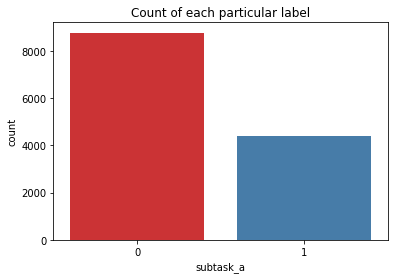

In [ ]:
# check label distribution
sns.countplot(x = "subtask_a", data = data_a, palette = "Set1")
plt.title("Count of each particular label")

Text(0.5, 1.0, 'Count of each particular label')

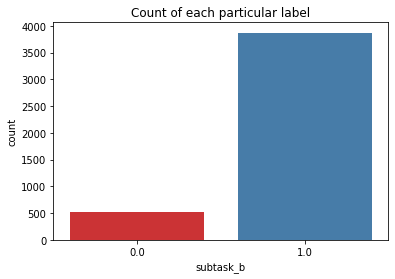

In [ ]:
# check label distribution
sns.countplot(x = "subtask_b", data = data_b, palette = "Set1")
plt.title("Count of each particular label")

Text(0.5, 1.0, 'Count of each particular label')

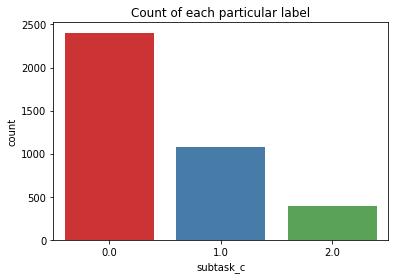

In [ ]:
# check label distribution
sns.countplot(x = "subtask_c", data = data_c, palette = "Set1")
plt.title("Count of each particular label")

Text(0.5, 1.0, 'Tweets lengths ditribution')

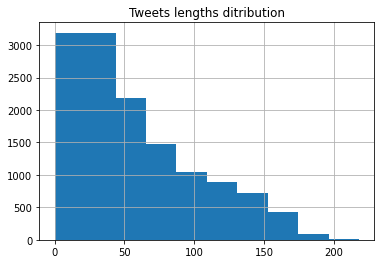

In [ ]:
# check length distribution
tweets.str.len().hist()
plt.title("Tweets lengths ditribution")

Text(0.5, 1.0, 'Pre-processed tweets lengths ditribution')

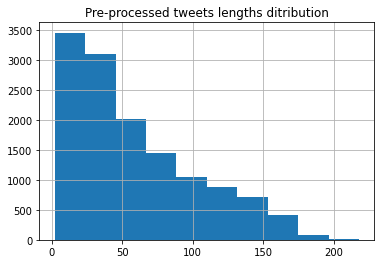

In [ ]:
# check length distribution
data['tweet'].str.len().hist()
plt.title("Pre-processed tweets lengths ditribution")

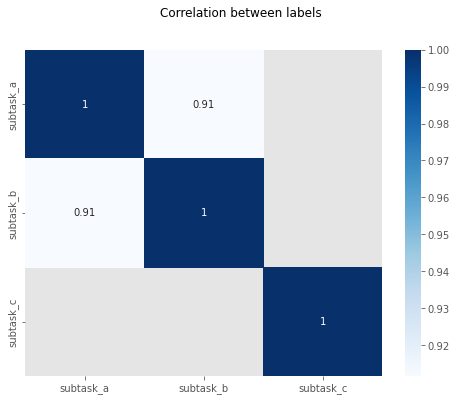

In [ ]:
# correlations
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))
fig.suptitle("Correlation between labels")
sns.heatmap(data[data.columns[1:]].corr(), annot = True, cmap = "Blues", ax = ax);

# Word2Vec

In [ ]:
# import pretrained word2vec
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# separate each word
dataset = []

for word in data['tweet']:
  dataset.append(word.split())

In [ ]:
# create our own word2vec model since there are words in our dataset
# which can't be found in the pretrained word2vec corpus
model = Word2Vec(dataset, min_count = 1, size = 300, window = 5, sg = 0)

In [ ]:
# verifying if the word in our dataset is found in the corpus.
# If yes, we take it from there, if not, we're taking the embedding from our model of word2vec
word_vec_train = []

for i in data['tweet']:
  value = None
  if 'havetaken' in i:
    i = i.replace("havetaken", 'have taken')
  for word in i.split(" "):
    if len(i) == 0:
      continue
    if word in word2vec:
      if value is None:
        value = word2vec[word]
      else:
        value = value + word2vec[word]
    else:
      if value is None:
        value = model[word]
      else:
        value = value + model[word]
  # print(i)
  value = value / len(i.split())
  word_vec_train.append(value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# CNN

In [ ]:
# defining the class
class my_class(torch.utils.data.Dataset):
  
  def __init__(self, X, y):
    self.X = torch.from_numpy(X)
    self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i].unsqueeze(0), self.y[i]

In [ ]:
# CNN model made after the one in the paper, the only difference is that we used
# the Sigmoid function as we have binary values 
# and Softmax is used for multiclass classifications.
# We also added an activation function, ReLU and a layer of Linear so that
# we have the suitable output to use in our CNN model.

class CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv1d(1, 100, 2, stride = 1),
      nn.Conv1d(100, 100, 3, stride = 1),
      nn.Conv1d(100, 100, 4, stride = 1),
      nn.MaxPool1d(4, stride = 4),
      nn.MaxPool1d(4, stride = 4),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(1800, 1),
      nn.Sigmoid())

  def forward(self, x):
    return self.layers(x).squeeze(1)

In [ ]:
# splitting the data for both subtask a and subtask b
X_train, X_test, y_train, y_test = train_test_split(word_vec_train, data[['subtask_a', 'subtask_b']].values,
                                                    test_size = 0.33, random_state = 42)

In [ ]:
# Creating train dataloader
dataset = my_class(np.array(X_train), np.array(y_train[:,0]))
train_loader = DataLoader(dataset, batch_size = 8, shuffle = True)

In [ ]:
# Creating test dataloader
dataset_test = my_class(np.array(X_test), np.array(y_test[:,0]))
test_loader = DataLoader(dataset_test, batch_size = 1, shuffle = False)

In [ ]:
# number of epochs
epochs = 15

# initialize the CNN
print("Cuda available?", torch.cuda.is_available())
cnn = CNN().cuda()

# define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 1e-4)
optimizer.zero_grad() 

Cuda available? True


In [ ]:
# defining the train function
def train_function(epochs: int, train_loader: DataLoader, test_loader: DataLoader):
  
  use_cuda = True
  for e in range(epochs):
    cnn.train()
    for val, label in train_loader:
      val = val.cuda()
      label = label.cuda()

      optimizer.zero_grad()
      out = cnn(val)

      loss = loss_function(out.float(), label.float())
      loss.backward()
      optimizer.step()

    print("The loss for the epoch {} is {:.8f}".format(e, loss.item()))

    count = len(test_loader)
    correct = 0
    predicts = []
    cnn.eval()
    with torch.no_grad():
        for test_val, test_label in test_loader:
            if use_cuda:
                pred = -1
                test_val = test_val.cuda()
                test_label = test_label.cuda()
                out_class = cnn(test_val)
                if out_class > 0.5:
                  pred = 1
                else:
                  pred = 0
                predicts.append(pred)
  
            if pred == test_label:
                correct += 1

    print("The accuracy for the epoch {} is {:.2f}%\n".format(e, (correct / count) * 100))

  return predicts

In [ ]:
predicts = train_function(epochs, train_loader, test_loader)

The loss for the epoch 0 is 0.57230091
The accuracy for the epoch 0 is 65.89%

The loss for the epoch 1 is 0.43747869
The accuracy for the epoch 1 is 70.89%

The loss for the epoch 2 is 0.73839611
The accuracy for the epoch 2 is 72.11%

The loss for the epoch 3 is 0.17351721
The accuracy for the epoch 3 is 72.36%

The loss for the epoch 4 is 0.47801477
The accuracy for the epoch 4 is 72.34%

The loss for the epoch 5 is 1.18909645
The accuracy for the epoch 5 is 73.83%

The loss for the epoch 6 is 0.63896120
The accuracy for the epoch 6 is 73.39%

The loss for the epoch 7 is 0.49878892
The accuracy for the epoch 7 is 73.86%

The loss for the epoch 8 is 0.39222047
The accuracy for the epoch 8 is 73.65%

The loss for the epoch 9 is 0.43549070
The accuracy for the epoch 9 is 73.95%

The loss for the epoch 10 is 0.86202902
The accuracy for the epoch 10 is 73.58%

The loss for the epoch 11 is 0.70253080
The accuracy for the epoch 11 is 73.51%

The loss for the epoch 12 is 0.25423232
The accu

In [ ]:
# CNN's confusion matrix
confusion_matrix(y_test[:,0], predicts)

array([[2718,  145],
       [1015,  467]])

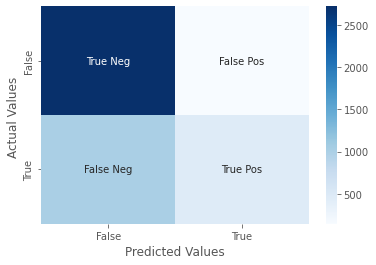

In [ ]:
arr = confusion_matrix(y_test[:,0], predicts)

labels = ['True Neg','False Pos','False Neg','True Pos']

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(arr, annot = labels, fmt = '', cmap = 'Blues')

ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [ ]:
# CNN's precision
precision_score(y_test[:,0], predicts, average = 'macro')

0.7455863093518504

In [ ]:
# CNN's recall
recall_score(y_test[:,0], predicts, average = 'macro')

0.6322342672555

In [ ]:
# CNN's F1
f1_score(y_test[:,0], predicts, average = 'macro')

0.6350860670384008

# Other Models

In [ ]:
# helper function for model training
def train_model(clf, X_train, X_test, y_train, y_test):
  clf.fit(np.array(X_train), np.array(y_train))
  prediction = clf.predict(X_test)
  print("Score:", accuracy_score(y_test, prediction))


In [ ]:
clf = svm.SVC(kernel = 'rbf', C = 5)
train_model(clf, X_train, X_test, y_train[:,0], y_test[:,0])

Score: 0.7514384349827388


In [ ]:
#SVM F1 macro score
f1_score(y_test[:,0], prediction, average='macro')

0.6983355807416137

In [ ]:
clf = SGDClassifier(loss = "hinge", penalty = "l1", max_iter = 10)
train_model(clf, X_train, X_test, y_train[:,0], y_test[:,0])

Score: 0.7159953970080553


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [ ]:
clf = tree.DecisionTreeClassifier(random_state = 0, max_depth = 5)
train_model(clf, X_train, X_test, y_train[:,0], y_test[:,0])

Score: 0.6918296892980438


In [ ]:
clf = RandomForestClassifier(n_estimators = 1500, max_depth = 5, random_state = 0, n_jobs = -1)
train_model(clf, X_train, X_test, y_train[:,0], y_test[:,0])

Score: 0.6980437284234753


In [ ]:
clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0,
    max_depth = 1, random_state = 0, loss = 'exponential', criterion = 'squared_error', max_features = 'log2')
train_model(clf, X_train, X_test, y_train[:,0], y_test[:,0])

Score: 0.7268124280782509


In [ ]:
# test model for subtask B
clf2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0,
    max_depth = 1, random_state = 0, loss = 'exponential', criterion = 'squared_error', max_features = 'log2')
train_model(clf2, X_train, X_test, y_train[:,1], y_test[:,1])

Score: 0.7293440736478711


In [ ]:
# other data
pred1 = clf.predict(X_test)
pred2 = clf2.predict(X_test)

pred2[pred1 == 0] = 0

print("Number of matches:", (pred1 == pred2).sum())

# Combined the predictions, calculated the accuracy of how our data is predicted with subtask_b based on subtask_a
accuracy_score(np.array([pred1, pred2]).reshape(pred1.shape[0], 2), y_test)

Number of matches: 3883


0.4386651323360184